## Conversion Rate Challenge

Le projet Convertion Rate Challenge concerne le site `https://www.datascienceweekly.org/` qui est un blog type news letter de data science qui permet, après inscription sur leur site, de recevoir des news letter chaque semaine.

Les data scientists qui ont créé la newsletter souhaitent mieux comprendre le comportement des utilisateurs visitant leur site web. Ils aimeraient savoir s'il est possible de construire un modèle qui prédit si un utilisateur donné s'abonnera à la newsletter, en utilisant seulement quelques informations sur l'utilisateur. Ils aimeraient analyser les paramètres du modèle pour mettre en évidence des fonctionnalités importantes pour expliquer le comportement des utilisateurs, et peut-être découvrir un nouveau levier d'action pour améliorer le taux de conversion de la newsletter.

Ils ont conçu un concours visant à construire un modèle permettant de prédire les conversions (c'est-à-dire quand un utilisateur s'abonnera à la newsletter). Pour ce faire, ils ont ouvert un ensemble de données contenant des données sur le trafic sur leur site Web. Pour évaluer le classement des différentes équipes en compétition, ils ont décidé d'utiliser le f1-score.

**Objectif** : prédire le taux de conversion à la news letter grace à des paramètres concernant le traffic sur leur site web en utilisant le f1 score comme métrique d'accuracy

Pour rappel :</br>
* **F1-score** : $F_{1}=\frac{\text{Precision}\space  \times \space \text{Recall}}{\text{Precision} \space + \space \text{Recall}}=\frac{2 \space \times \space \text{True Positive}}{2 \space \times \space \text{True Positive} \space + \space \text{False Positive} \space + \space \text{False Negative}}$

C'est la métrique de classification qui mesure la capacité d'un modèle à **bien prédire les individus positifs**, tant en termes de `precision` (taux de prédictions positives correctes) qu'en termes de `recall` (taux de positifs correctement prédits). Il s’inscrit dans la famille des **Fbeta-scores**, qui introduisent une pondération de la precision par rapport au recall, et permettent de s’adapter à des situations spécifiques où l’un des deux indicateurs est privilégié. Pour un **modèle non-informatif** il vaut **2p/(p+1)**, où **p** est le taux de positifs dans les données. le F1-score a en commun avec l’accuracy de résumer la performance d’un modèle en un seul indicateur pour chaque seuil de classification. Il est plus complexe mais a l’avantage d’être robuste en présence de données déséquilibrées (Ce qui est notre cas)


* **Precision** : $Precision = \frac{\text{True Positive}}{\text{True Positive} \space + \space \text{False Positive}}$

C'est le `Taux de prédictions positives correctes` : elle permet de connaître le nombre de **prédictions positifs bien effectuées**. En d’autres termes c’est le nombre de **positifs bien prédit (Vrai Positif)** divisé par l’**ensemble des positifs prédit (Vrai Positif + Faux Positif)**. Plus **elle est élevé**, plus le modèle de Machine Learning **minimise le nombre de Faux Positif**. Quand la **précision est haute**, cela veut dire que la **majorité des prédictions positives du modèle** sont des **positifs bien prédit**.


* **Recall** : $Recall = \frac{\text{True Positive}}{\text{True Positive} \space + \space \text{False Negative}}$

C'est le `Taux de positifs correctement prédit` : il permet de savoir le pourcentage de **positifs bien prédit par notre modèle**. En d'autres termes c’est le nombre de **positifs bien prédit (Vrai Positif)** divisé par l’**ensemble des positifs** (Vrai Positif + Faux Négatif). Plus **il est élevé**, plus le modèle de Machine Learning **maximise le nombre de Vrai Positif**. Mais cela ne veut pas dire que le modèle ne se trompe pas. Quand le **recall est haut**, cela veut plutôt dire qu’il ne **ratera aucun positif**. Néanmoins cela ne donne aucune information sur sa qualité de prédiction sur les négatifs.

Nous préferons utiliser le **F1-score** plutot que l'**Accuracy** comme métric car l'accuracy va être faussée par le déséquilibre de classe à prédire (par ex, si il n'y a que 5 % de personnes qui se sont abonnées, avec un modèle complétement random qui prédit donc aléatoirement les classes, nous allons nous retrouver avec 95 % d'accuracy). Alors que si nous prenons une métric comme le F1-score, qui va détecter les faux positifs et les faux négatives (qui va prendre en compte les mauvaises prédicitions) nous allons nous retrouver avec un score qui se rapproche plus de la réalité des prédictions (et qui va donc pénaliser des modèles qui font de l'overfitting en ne prédisant que les classes majoritaires)

**Conclusion**

**`Plus`** le **recall est haut**, **`plus`** le **modèle repère de positif**</br>
**`Plus`** la **precision est haute**, **`moins`** le **modèle se trompe sur les positifs**

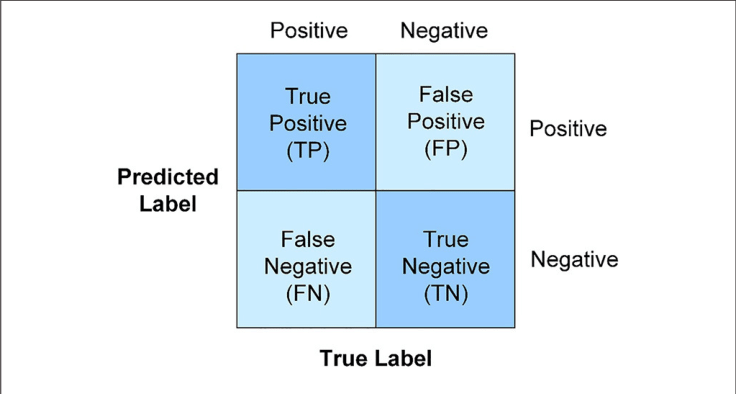

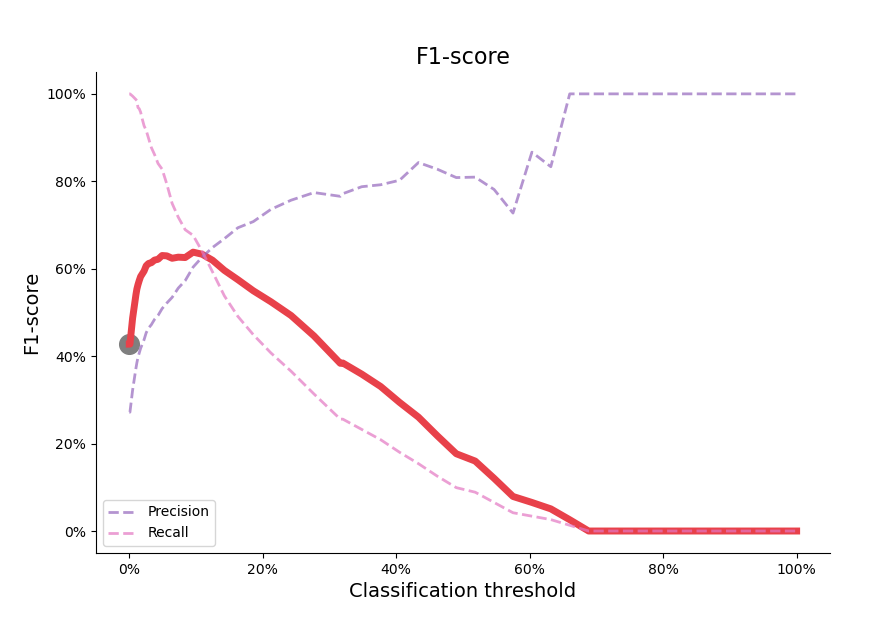

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" 
from IPython.display import display

# METHODOLOGIE

Pour ce projet, nous sommes face à des classes déséquilibrées (beaucoup de gens ne s'abonnent pas et très peu de gens s'abonnent à la news letter), nous allons donc devoir nous adapter, ne pas prendre de conclusion trop hative et trouver des techniques qui vont nous permettre de pouvoir pallier ce problème. De plus, nous sommes façe à un problème de classification : une personne s'abonne ou pas. Nous allons donc utiliser comme modèle de Machine Learning des techniques adaptées.

## 1. Exploratory Data Analysis

### Objectif :

* Comprendre du mieux possible nos données : 
* Développer une premiere stratégie de modélisation


#### Analyse de Forme :

* variable target : **`converted`** : est-ce qu'une personne visitant le site s'abonne à la newsletter
* lignes et colonnes : 
    * lignes : 284580
    * colonnes : 6
* types de variables : 
    * qualitatives : 4 variables ==> **`country`**(string), **`new_user`**(binaire), **`source`**(string) et **`converted`**(binaire)
    * quantitatives : 2 variables ==> **`age`**(discrete) et **`total_pages_visited`**(discrete)
* Analyse des valeurs manquantes :
    * Aucune valeur manquante
    
#### Analyse de Fond :

* Visualisation de la target :
    * 96.7% de negatifs (non-abonnés) ==> (9180 / 284580) 
    * 3.3% de positifs (personnes qui se sont abonnés) ==> (275400 / 284580)
* Signification des variables :
    * variables numeriques discrètes : **`age`**(discrete), **`total_pages_visited`**
    * variable qualitative : 
        * binaire (0, 1) : **`new_user`**, **`converted`**(target)
        * nominale : **`country`**, **`source`**
* Relation Variables / Target :
    * target / country : 
    * target / age :   
    * target / new_user :  
    * target / source : 
    * target / total_pages_visited : 

In [3]:
#df = pd.read_csv('./src/conversion_data_train.csv')
df = pd.read_csv('./FULLSTACK/10_PROJECT/Conversion rate challenge/conversion_data_train.csv')
df.shape

(284580, 6)

In [5]:
display(df.head())
display(df.describe(include="all"))
display(df.isna().sum() / df.shape[0])

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


,country,age,new_user,source,total_pages_visited,converted
count,284519,284519.000000,284519.000000,284519,284519.000000,284519.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160085,NaN,NaN,139457,NaN,NaN
mean,NaN,30.564743,0.685532,NaN,4.868884,0.032051
std,NaN,8.263681,0.464304,NaN,3.328798,0.176135
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

Il y a 6 colonnes dans notre dataset :</br>
* **country** : représente le pays de la personne qui visite le site
* **age** : age de la personne qui visite le site
* **new_user** : catégorie binaire si la personne est un nouvel utilisateur ou non
* **source** : par quel moyen la personne est arrivée sur le site(publicité, lien de redirection, elle-même)
* **total_pages_visited** : nombre de page que la personne à regardé sur le site
* **converted** : c'est notre target, à savoir si une personne s'est abonnée ou pas à la news letter

Il n'y a pas de valeurs manquantes. De plus, on peut observer différentes statistiques qui va nous éclairer sur l'approche que nous allons adapter pour trouver des solutions à notre problématique.

* **country** : Il y a 4 pays différents avec une majorité de personnes américaines (plus de la moitié, ce qui est logique puisque le site est US)
* **age** : L'age minimum est de 17 ans alors que celui le plus agé est de 123 ans ( il peut avoir des possibilités d'outliers sur cette colonne mais est possible que cette personne est réellement 123 ans ou la personne s'est trompé quand elle à rentré son age (23 ans?)
* **new_user** : Plus de la moitié des personnes qui visitent ce site sont nouvelles (1) vu que la moitié est à 1
* **source** : Il y a 3 possibilités de venus sur le site (soit la personne connait le site ou par le bouche à oreille, soit par une publicité, soit par un moteur de recherche) : la majorité viennent par moteur de recherche 
* **total_pages_visited** : Le nombre de page visitée varie de 1 à 29 avec la moitié des personnes qui regardent 4 pages en moyenne (possibilité d'outliers aussi pour cette feature
* **converted** : la moyenne des personnes qui s'abonnent à la newsletter etant de 0.03 on voit qu'il y a un déséquilibre extreme sur la target (dans un autre notebook, nous allons tester des techniques de réechantillonnage en générant (et ainsi augmenter) des samples qui sont de la classe minoritaire pour équilibrer et éviter l'overfitting

In [6]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [7]:
df['new_user'].value_counts() / df.shape[0]

1    0.685532
0    0.314468
Name: new_user, dtype: float64

In [8]:
df['converted'].value_counts()  / df.shape[0]

0    0.967949
1    0.032051
Name: converted, dtype: float64

Nous pouvons aussi remarquer en approfondissant nos analyses que plus de 2/3 des personnes qui visitent le site sont nouvelles et qu'il y a bien un déséquilibre extreme des classes (la precision et le recall vont pouvoir nous dire comment le modèle réussi à prédire les bonnes classes)

## EDA

### Types de variables

In [9]:
categ_str_features = ['country', 'source']
categ_int_features = ['new_user']
numeric_features = ['age', 'total_pages_visited']
target = 'converted'

Comme nous l'avons remarqué précedemment, il y a des **variables catégorielles** (`country`, `source`, `new_user`, `converted`) et **numériques** (`age`, `total_pages_visited`). Nous allons aussi séparer la target (qui est une variable catégorielle) des autres variables.

Nous allons effectuer une Analyse univarié (une seule variable) puis bivariée (variable1 / variable2) et observer les résultats

### Analyse univariée des variables 

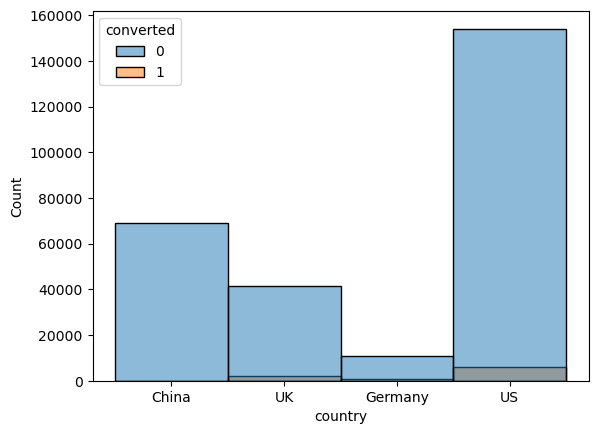

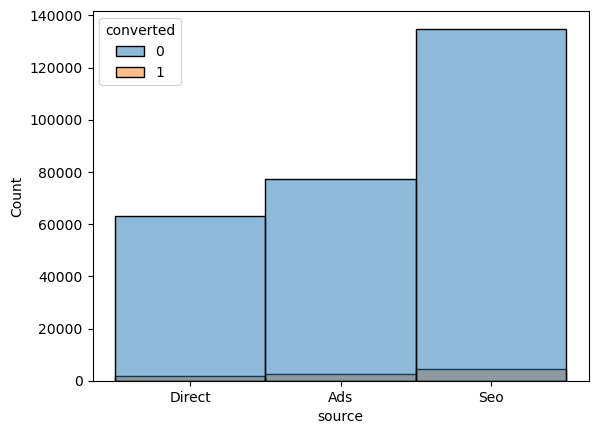

In [10]:
for col in categ_str_features:
    plt.figure()
    sns.histplot(data = df, x=col, hue=target)

Pour les variables **catégorielles objet**:</br>
* **`country`** : on remarque bien une grande majorité de personnes américaines visitant le site, on peut voir aussi un grand nombre de personnnes asiatiques (plus que les anglais). Par contre nous voyons très peu d'européens (seule l'allemagne est représentée et cela concerne un nombre relativement faible de personne). Un fait interessant que l'on peut constater et qu'il y a moins d'anglais que de chinois qui visitent le site mais les anglais sont plus nombreux à s'être abonnés

* **`source`** : on observe une majorité de personnes provenant de moteur de recherche (Seo) arrivant sur le site, une tranche intermédiare concernant la publicité (Ads : Advertising) et enfin une minorité de personne venant d'elle même ou par un lien de redirection sans être une publicité ou un moteur de recherche (peut être comme nous avec le lien de Jedha pour faire notre projet) Nous remarquons également un abonnement proportionnelle à la classe représentée

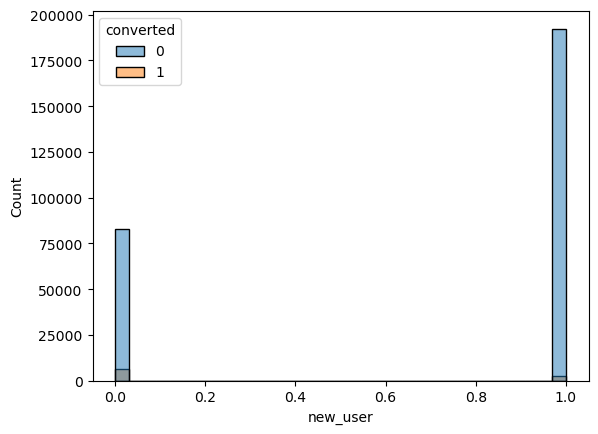

In [11]:
for col in categ_int_features:
    plt.figure()
    sns.histplot(data = df, x=col, hue=target)

Pour la variable **catégorielle numérique(binaire)** :
    
* **`new_user`** : on voit que la plupart des personnes visitant le site sont des nouveaux utilisateurs et le taux d'abonnement est inversement proportionnelle à la classe représentée : il y a 2 fois plus de nouveaux utilisateurs que de personnes qui sont déja venu sur le site mais ces anciens utilisateurs sont 2 fois plus nombreux à s'abonner que les nouveaux

<Figure size 640x480 with 0 Axes>

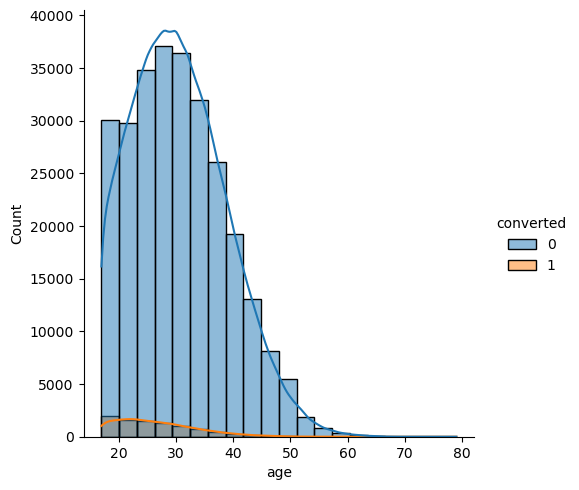

<Figure size 640x480 with 0 Axes>

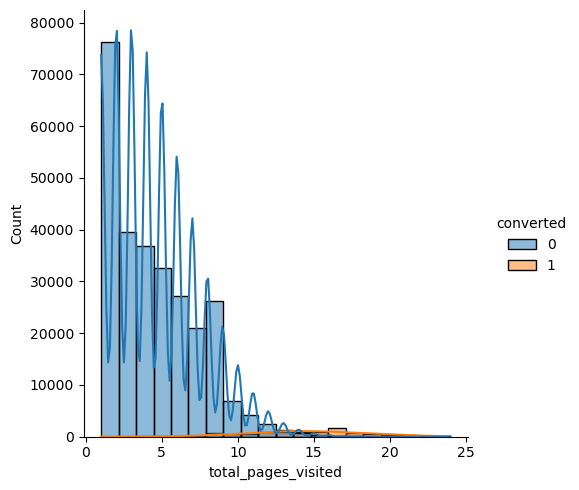

In [12]:
for col in numeric_features:
    plt.figure()
    sns.displot(data = df, x=col, hue=target, bins=20, kde=True)

En ce qui concerne les variables **numériques**:</br>
* **`age`** : on remarque une proportion de personnes visitant le site dans une tranche d'age allant de 18 à 50 ans en moyenne (la personne qui a 123 ans est donc un bien un outlier, nous allons voir plus tard si nous la gardons ou pas), nous voyons aussi que plus la personne est agée, moins il y a une chance qu'elle s'abonne à la newsletter

* **`total_pages_visited`** : on observe une majorité de personnes qui visitent peu voir très peu de pages avec une décroissance quasi exponentielles du nombre de page visitées (il y a tellement peu de personnes qui s'abonnent que ce graphique est difficilement interprétable en terme de taux d'abonnement et nous allons donc devoir observer un autre graphique plus basé sur la densité que le nombre de personne représentés pour interpréter ces résultats)

### Analyse en fonction de 'converted'

on va créer 2 groupes : `converted == 'yes'` et `converted == 'no'` ce qui va nous permettre par la suite de faire des tests d'echantillonnage et aussi de pouvoir visuellement représenter ces catégories en superposant leur distributionà

In [13]:
converted = df[df['converted'] == 1]
non_converted = df[df['converted'] == 0]

In [14]:
print(len(converted))
print(len(non_converted))

9119
275400


### Relation Target / Numerical

#### (Target / Age) & (Target / Total_pages_visited)

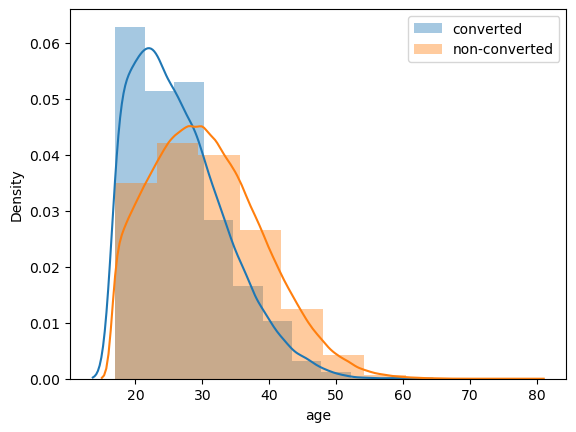

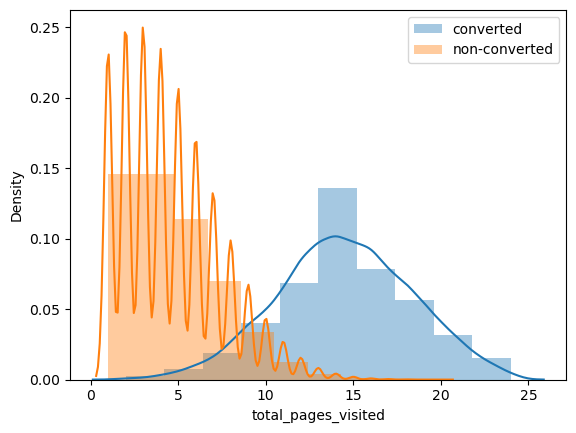

In [15]:
for col in numeric_features:
    plt.figure()
    sns.distplot(converted[col], label='converted', bins=10)
    sns.distplot(non_converted[col], label='non-converted',bins=10)
    plt.legend()

Autant pour l'`age` dont on ne voit pas bien une différence entre la distribution des personnes qui se sont abonnées et celles qui ne l'ont pas fait, autant on observe bien 2 distributions différentes pour `total_pages_visited` en fonction si une personne s'est abonné ou pas : si une personne s'abonne, elle visite en moyenne 15 pages alors que pour les personnes qui ne sont pas abonner à la newsletter, elles ont visité en moyenne que 5 pages seulement : il faudrait peut etre que les 5 premières pages soient très interessantes pour pousser les personnes à s'abonner.

### Relation Target / Categorical

Pour les variable catégorielles, nous pouvons remarquer que le déséquilibre des classes entraine un problème de visibilité des matrices de tables de comparaison. en revanche, on peut observer des phénomènes que l'on a déja étudier auparavent

#### Target / Country

country,China,Germany,UK,US
converted,,,,
0,0.998727,0.938131,0.947808,0.962326
1,0.001273,0.061869,0.052192,0.037674


<AxesSubplot:xlabel='country', ylabel='converted'>

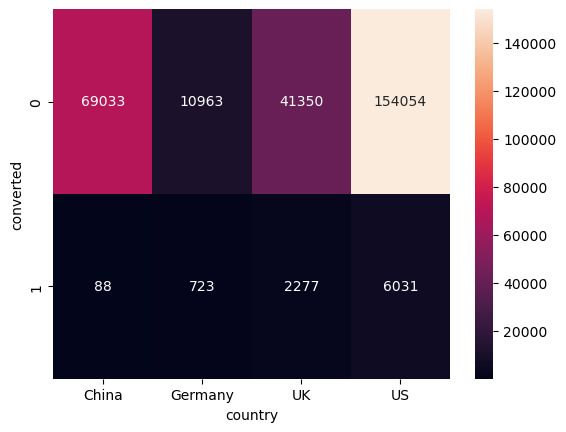

In [16]:
display(pd.crosstab(df['converted'], df['country'], normalize='columns'))
plt.figure()
sns.heatmap(pd.crosstab(df['converted'], df['country']), annot=True, fmt='d')

En comparant la variable `country` avec le nombre de personne qui s'abonne, on remarque de manière plus précise un très faible taux d'abonnement pour les personnes asiatiques, et, fait interessant, le taux d'abonnement le plus élevé concerne la classe minoritaire des pays, cad l'Allemagne. Les américains, alors qu'ils sont majoritairement à venir sur ce site, ont un taux plus faible que les allemands

#### Target / Source

source,Ads,Direct,Seo
converted,,,
0,0.965489,0.97244,0.967266
1,0.034511,0.02756,0.032734


<AxesSubplot:xlabel='source', ylabel='converted'>

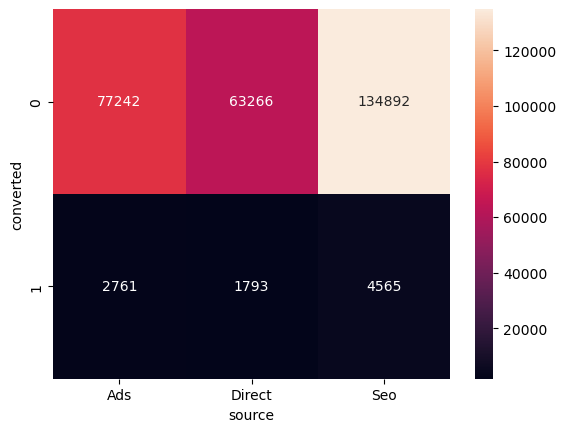

In [17]:
display(pd.crosstab(df['converted'], df['source'], normalize='columns'))
plt.figure()
sns.heatmap(pd.crosstab(df['converted'], df['source']), annot=True, fmt='d')

En ce qui concerne la source des personnes qui viennent sur ce site, on remarque une homogénité dans le taux d'abonnement qui se situe en moyenne à 3% avec une légère baisse de ce taux pour les personnes venant directement sur le site ou sans passer par un moteur de recherche. De plus, plus les personnes viennent directement sur le site, moins il y a de chance qu'elles s'abonnent. 

#### Target / New_user

new_user,0,1
converted,,
0,0.928503,0.986044
1,0.071497,0.013956


<AxesSubplot:xlabel='new_user', ylabel='converted'>

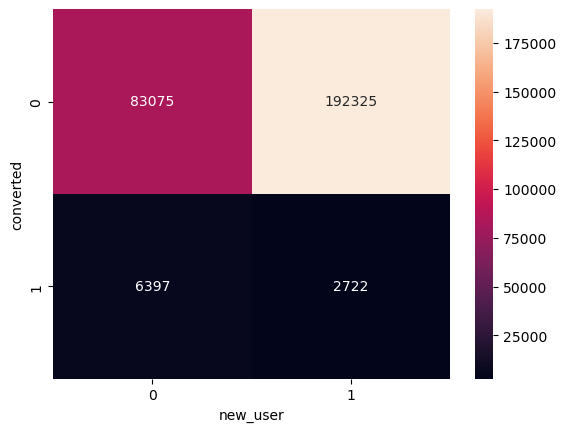

In [19]:
display(pd.crosstab(df['converted'], df['new_user'], normalize='columns'))
plt.figure()
sns.heatmap(pd.crosstab(df['converted'], df['new_user']), annot=True, fmt='d')

On remarque enfin pour les nouveaux utilisateurs qu'ils sont nombreux à ne pas s'abonner (+98%) alors que les utilisateurs qui connaissent déja le site sont seulement 92% à ne pas prendre d'abonnement à la newsletter.

### Removing outliers

Nous retirons les outliers rencontrés en se fixant sur les graphiques précedents : tous les ages supérieurs à 80 et le nombre de page visitée supérieur à 25

In [20]:
df = df[(df['age'] < 80) & (df['total_pages_visited'] < 25)]

Nous allons puvoir passer à l'étape du preprocessing des données pour être utilisées afin d'assurer et d'améliorer les performances de nos modèles

### Preprocessing

Le preprocessing va consister à séparer notre jeu de données en 2 (un pour l'entrainement et un autre pour tester les resultats de nos différents modèles). Il consiste donc en 2 étapes:</br>

**Preparation de données** : 

nous allons normaliser, c'est à dire mettre toutes les variables sur une même echelle ce qui permettra à ce que le coefficient d'une variable de notre modèle n'ai pas trop de poids par rapport à une autre, et cela va aussi augmenter les vitesses de calculs


**Model training** : 

cette étape concerne l'entrainement de tous les modèles après avoir mis dans des **pipelines**, d'avoir entrainer le modèle sur le train et de transformer les valeurs sur le test pour éviter un **leakage** (fuite de données entre le train et le test). Nous allons devoir **trouver les meilleurs hyper-paramètres** de nos modèles en cherchant, par dichotomie (ou binary search), cad en créant des ranges de valeurs de plus en plus petit jusqu'a trouver le ou les hyper-paramètres adéquates à l'entrainement (cette recherche d'hyper-paramètres se fera avec une **GridSearchCV**, qui est une technique de **K-Fold Cross Validation** : c'est une méthode d’estimation de fiabilité d’un modèle fondée sur une technique d’échantillonnage (on découpe notre jeu de données en **K-Folds**, on prend plusieurs echantillons aléatoires que l'on va rééchantillonner `sans remplacement` et on va produire des ensembles de données de **substitution plus petits que l'original**. Ces ensembles de données sont produits de manière systématique de sorte qu'après un nombre prédéfini **K** d'ensembles de données de substitution, chacun des cas originaux **n** ont été omis exactement une fois (leave-x-out cross validation) avec $x = \frac{n}{k}$, par exemple, leave-one-out cross validation omet 1 cas pour chaque ensemble de substitution, c'est-à-dire $k = n$.

Attention à ne pas confondre avec une autre technique d'echantillonnage qui est le **Bootstrapping** : il rééchantillonne `avec remplacement` (et produit généralement de nouveaux ensembles de données **de substitution avec le même nombre de cas que l'ensemble de données d'origine**). En raison du **tirage avec remplacement**, un ensemble de données amorcé peut contenir **plusieurs instances des mêmes cas d'origine** et peut **omettre complètement d'autres cas d'origine**.

Enfin, nous allons étudier le score de cross validation en regardant la moyenne ainsi que l'ecart type pour savoir si les resultats sont **statistiquement significatifs**

**Rappel : Différence entre paramètres et hyperparamètres d'un modèle**:

* **Paramètres du modèle** : ils sont estimés automatiquement à partir des données(features) 
* **Hyper-paramètres du modèle** : ils sont définis manuellement et sont utilisés dans les processus pour aider à estimer les paramètres du modèle (attention ! Les hyperparamètres de modèle sont souvent appelés paramètres car ce sont les parties de l'apprentissage automatique qui doivent être définies manuellement)

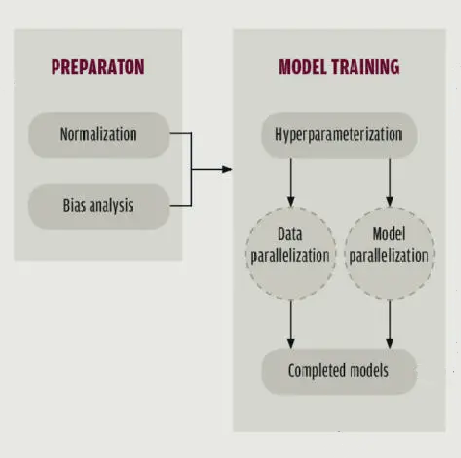

On découpe notre jeu de donnée une première fois en deux pour séparer les features explicatives indépendantes de la target expliquée dépendante puis on va séparer une deuxième fois ces 2 parties (X et y) pour avoir un ensemble d'entrainement et un ensemble de test.

In [21]:
X = df.iloc[:, :-1]
y = df.loc[:, 'converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

On sépare nos features 2 listes : une pour les catégories et une pour les valeurs numériques. On va appliquer un `StandardScaler` pour les variables numériques et un `One Hot Encoder` pour les variables catégorielles.

In [25]:
numeric_features = ['age', 'total_pages_visited']
categ_features = ['country', 'source', 'new_user']

num_transf = StandardScaler()

categ_transf = OneHotEncoder(drop='first')

preprocessor = make_column_transformer(
    (num_transf, numeric_features),
    (categ_transf, categ_features),
    remainder='passthrough'
)

On crée une simple Pipeline avec 4 modèles différents:

* Un modèle de **Regression logistique** qui va permettre à faire de la classification en fonction de la probabilité d'obtenir à une classe
* Un modèle de **Decision Tree** qui va, à partir d'un certain seuil de valeur, de pouvoir séparer en 2 groupes successivement en fonction de la feature selectionnée par le Decision Tree
* Un modèle de **Random Forest** qui est un Ensemble de Decision Tree (on regroupe plusieurs Decision Tree puis on prend le meilleur)
* Un modèle de **Support Vector Machine** qui va déterminer une marge (une zone de delimitation à partir du plan de séparation (hyperplan si quadratique)) grace à des vecteurs de support qui sont aux extrémités de la marge

Nous allons comparer les résultats

In [ ]:
# Attention ! en fonction de la version de sklearn, il est possible que regressors retourne une erreur de type : 
# TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough'
# Dans ce cas, il va falloir un peu changer le code comme ceci :
'''
log_reg = LogisticRegression()
dec_tre = DecisionTreeClassifier()
ran_for = RandomForestClassifier()
svc_svm = SVC()

regressors = [log_reg, dec_tre, ran_for, svc_svm]'''

regressors = make_pipeline(
    (LogisticRegression()),
    (DecisionTreeClassifier()),
    (RandomForestClassifier()),
    (SVC())
)

In [46]:
pip1 = make_pipeline(
    (preprocessor),
    (regressors)
)

pip1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'total_pages_visited']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source',
                                                   'new_user'])])),
                ('pipeline',
                 Pipeline(steps=[('logisticregression', LogisticRegression()),
                                 ('decisiontreeclassifier',
                                  DecisionTreeClassifier()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier()),
                                 ('svc', SVC())]))])

Notre pipeline est prête pour le preprocessing ! Nous allons appliquer les preprocessors et les regressors sur notre train et notre test

In [49]:
X_train = pip1[0].fit_transform(X_train)
X_test = pip1[0].transform(X_test)

In [47]:
pip1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'total_pages_visited']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source',
                                                   'new_user'])])),
                ('pipeline',
                 Pipeline(steps=[('logisticregression', LogisticRegression()),
                                 ('decisiontreeclassifier',
                                  DecisionTreeClassifier()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier()),
                                 ('svc', SVC())]))])

Maintenant, nous allons pouvoir essayer plusieurs modèles et comparer les résultats

### LogisticRegression

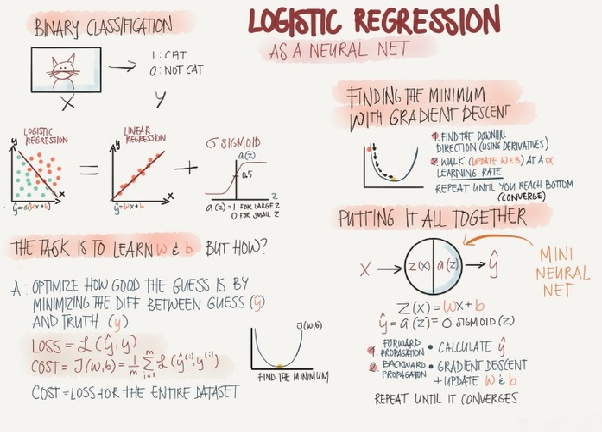

La **régression logistique** ou **modèle logit** est un modèle de **régression binomiale**(cad il explique au mieux une variable binaire (la présence ou l'absence d'une caractéristique donnée)). Il consiste à associer une **variable aléatoire de Bernoulli** (génériquement notée $y$ qui est notre target) à un vecteur de variables aléatoires ($x_{1}, ... ,x_{K}$) La régression logistique ne doit pas être confondue avec un modèle de régression car c'est bien un **modèle de classification** qu va nous permettre de classifier si un individu s'est abonnée à la newsletter(1) ou non(0)

Les **hyperparametres** de la **LogisticRegression** sont:
    
* **`C`** : C'est l'`inverse de la force de régularisation` : La régularisation pénalise les paramètres extrêmes, les valeurs extrêmes dans les données d'entraînement conduisent à un overfitting. Une valeur élevée de C indique au modèle d'accorder un poids élevé aux données de train et un poids inférieur à la pénalité de complexité(qui est une pénalité pour des paramètres plus extrêmes). Une valeur faible indique au modèle de donner plus de poids à cette pénalité de complexité au détriment de l'ajustement aux données du train. En généralisant, un **C élevé** signifie une **certaine fiabilité aux données du train** tandis qu'un **C faible** indique **manque de confiance sur les données du train** et donc de **pénaliser les valeurs extrèmes du train**


* **`Penalty`** : impose une pénalité au modèle logistique pour avoir trop de variables. Cela se traduit par un rétrécissement vers zéro des coefficients des variables les moins contributives(régularisation). Il existe 2 types de penalités : **L1** qui est la **régularisation Lasso** (elle utilise la somme des valeurs absolues des paramètres et réduit donc des sommes possiblement à 0(supprime les variables les moins utiles et baissent les coefficients des variables qui ont trop de poids)) et la pénalite **L2** qui est la **régularisation Ridge** (elle utilise la somme des carrés des paramètres et réduit donc ces sommes vers 0 sans jamais l'atteindre : peut baisser les poids des variables qui en ont trop, réduire les poids des variables non importantes mais ne peut pas les supprimer)

* **`Solver`** : les solvers sont assez complexe à comprendre puisqu'ils permettent de résoudre des problèmes d'optimisation quadratique par descente de gradients. Certains d'entre eux utilisent de la mémoire à court terme pour éviter de faire ces descentes sur tout le dataset, d'autres utilisent des techniques de pénalité de régularisation (pour réduire ou supprimer des variables). Certains solvers comme **sag** et **saga** sont bien pour les datasets à beaucoup de données, comme celui que nous avons, et ils utilisent des techniques de régularisation (**L2** pour sag, **L1** pour saga) mais nous allons garder `lbfgs` qui une méthode similaire à la celle de Newton qui permet d'avoir des estimations de gradients approximatives pour augmenter la vitesse de convergence vers le minima local. Il utilise donc beaucoup moins de mémoire que sag ou sage mais demande de meilleurs ajustement de convergence (eviter d'etre dans un point de selle qui retarderai enormement la convergence, ce qui lui ferait préferer sag ou sage)

Nous allons donc faire du **Fine Tuning** d'hyperparamètres grace à une **GridSearch** pour trouver les meilleurs

On commence par etuder le `cross val_score` en ayant entrainer avec la **Logistic Regression** notre jeu de données et on regarde la moyenne et l'ecart-type

In [24]:
scores_lr = cross_val_score(pip1[1][0], X_train, y_train, cv=5)
print(scores_lr.mean())
print(scores_lr.std())

0.9863307301581349
0.0004115222348482242


On se retrouve avec un excellent score qui ne réprésente pas la réalité car il provient du déséquilibre des classes évoquées ultérieurement. l'ecart type est extrément faible donc attention à l'overfitting sur les résultats obtenus

On test sur un range de valeur pour `C` qui est de [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] et des pénalités `L1` ou `L2` : on fait une cross-validation sur 5 K-Folds, cad qu'on découpe notre jeu de données en 5, on test les 5 et on prendra les hyperparamètres de celui qui nous donne le meilleur résultat

In [111]:
params = {
    'C' : np.logspace(-3,3,7),
    'penalty' : ['l1','l2']
}

gridsearch_lr = GridSearchCV(pip1[1][0], param_grid = params, cv=5)
gridsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

On va tester les meilleures valeurs d'hyperparametres 

In [28]:
print("Best hyperparameters : ", gridsearch_lr.best_params_)
print("Best R2 score : ", gridsearch_lr.best_score_)

Best hyperparameters :  {'C': 10.0, 'penalty': 'l2'}
Best R2 score :  0.9863463476086849


Les hyperparametres retenus sont : `C` = 10 et `penalty` = 'l2'.
    
On peut en conclure que les données du train sont assez fiable et qu'il n'est pas nécessaire de supprimer des variables (on peut seulement baisser les coefs des features qui ont trop de poids par rapport aux autres)

In [30]:
y_train_pred_lr = gridsearch_lr.predict(X_train)
y_test_pred_lr = gridsearch_lr.predict(X_test)

In [31]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.7649788178333669
f1-score sur le test set :  0.7568513119533526


On obtient comme attendu un `F1-score` bien plus faible que le `R2-score`. Cela s'explique par le déséquilibre de classes et nous allons devoir utiliser des techniques d'augmentation de données pour espérer un meilleur résultat.

On peut déceler également un très leger overfitting (à confirmer!)

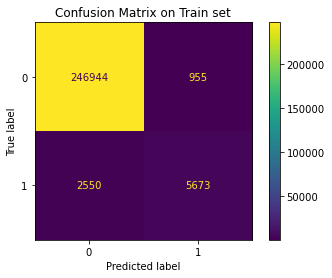

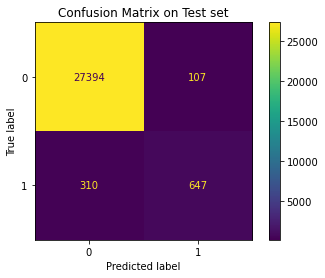

In [118]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_test, y_test, ax=ax) 
plt.show()

En analysant les matrices de confusions, on peut observer(sur le train par exemple):</br>
    
* **True Positive** : 5673
* **False Positive** : 955
* **Total Positive** : 6628
* **True Negative** : 246944
* **False Negative** : 2500
* **Total Negative** : 249444

On ne s'interesse pas à la **Precision/Recall** pour les $0$, seulement pour les $1$

### Precision(train)

$$Precision = \frac{\text{Positifs bien prédits}}{\text{Ensemble des positifs prédits}} = \frac{\text{Positifs bien prédits}}{\text{Positifs bien prédits} \space + \space \text{Negatifs mal prédits}}$$

$$Precision = \frac{5673}{6628} = \frac{5673}{5673 + 955} = 0.8559143029571514$$

**Le modèle repère les vrai $1$ à 85%, cad qu'il maximise le nombre de vrai $1$ à 85%**

### Recall(train)

$$Recall = \frac{\text{Positifs bien prédits}}{\text{Ensemble des positifs}} = \frac{\text{Positifs bien prédits}}{\text{Positifs bien prédits} \space + \space \text{Positifs mal prédits}}$$

$$Recall = \frac{5673}{8173} = \frac{5673}{5673 + 2500} = 0.6941147681389942$$

**Le modèle se trompe sur les $1$ à 31%, cad qu'il minimise le nombre de faux $1$ à 69%** 

In [40]:
print(classification_report(y_train, y_train_pred_lr))
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.86      0.69      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.92      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.86      0.68      0.76       957

    accuracy                           0.99     28458
   macro avg       0.92      0.84      0.87     28458
weighted avg       0.98      0.99      0.98     28458



Les scores entre le train et le test sont très similaires (il y a une très légère baisse sur le test qui peut faire penser à de l'overfitting mais ca reste très léger). Nous restons sur une `Precision` de $0.86$ et un `Recall` de $0.69$, ce qui donne un `F1-score` de 0.76

### Decision Tree

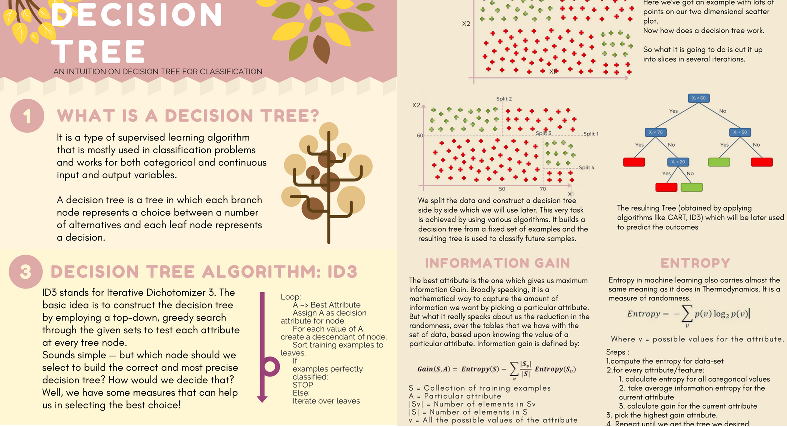

L'**arbre de décision** est un algorithme d'apprentissage supervisé largement utilisé qui convient à la fois aux tâches de classification et de régression. Les arbres de décision servent de blocs de construction pour certains algorithmes d'apprentissage d'ensemble importants tels que les forêts aléatoires, GBDT et XGBOOST. Un arbre de décision s'appuie sur des questions itératives pour partitionner les données.

Ils sont répandus dans le domaine du machine learning en raison de leur succès et de leur simplicité. Certaines des caractéristiques qui les rendent très efficaces :

* Facile à comprendre et à interpréter
* Peut gérer à la fois des données numériques et catégorielles
* Nécessite peu ou pas de prétraitement tel que la normalisation ou le dummy encoding(onehot)

Le modèle continue de diviser les nœuds jusqu'à ce que tous les nœuds soient purs (c'est-à-dire qu'ils contiennent des échantillons d'une seule classe)

Par contre, les arbres de décision sont sujets à l'**overfitting**. Ils peuvent facilement devenir trop complexes, ce qui les empêche de bien se généraliser à la structure du dataset. Dans ce cas, le modèle est susceptible de finir par être overfitté.

Pour surmonter ce problème, nous devons ajuster soigneusement les `hyperparamètres` des arbres de décision

Les **hyperparametres** des **DecisionsTree** sont:
    
* **`criterion`** :

il existe deux types possibles pour le choix de criterion : `gini` ou `entropy` qui permettent tous les 2 de mesurer l'**impureté** d'un noeud à chaque séparation, cad la qualité de la scission de chaque noeud d'un Decision tree

  * `gini` : c'est la mesure de la fréquence à laquelle un élément choisi au hasard dans l'ensemble serait mal étiqueté s'il était étiqueté au hasard en fonction de la distribution des étiquettes dans le sous-ensemble. L'**impureté augmente avec le hasard**. Si nous nous retrouvons en bas de l'arbre (une feuille) avec les mêmes echantillons, l'impureté est nulle. Au contraire, si chaque echantillon est unique, alors l'impureté est maximale est vaut 1. 
  * `entropy` : mesure de l'incertitude du caractère aléatoire. Plus une variable est aléatoire, plus son entropie est élevée.
    
Si tous les nœuds feuilles sont purs, alors l'arbre est trop spécifique et est susceptible de overfiter.

Lorsque l'algorithme effectue une séparation, l'objectif principal est de **réduire autant que possible les impuretés**. Plus l'**impureté diminue**, plus le **pouvoir informatif que la division gagne est grand**. Au fur et à mesure que l'arbre s'approfondit, la quantité d'impuretés diminue.


* **`min_impurity_decrease`** : On peut utiliser la diminution de l'impureté pour empêcher l'arbre de faire d'autres divisions (Il est mis à zéro par défaut). Plus on augmente la valeur de `min_impurity_decrease`, plus on raccourci l'arbre ce qui évite l'overfitting, mais moins le modèle est complexe, ce qui peut entrainer un problème de biais du modèle.


* **`min_impurity_split`** : il est utilisé pour contrôler l'arbre en fonction des valeurs d'impureté. Il fixe un seuil sur le gini. Par exemple, si min_impurity_split est défini sur 0,3, un nœud doit avoir une valeur de Gini supérieure à 0,3 pour être davantage divisé.


* **`max_depth`** : permet de contrôler la profondeur d'un arbre. Il ne fait aucun calcul concernant les impuretés ou le rapport d'échantillon. Le modèle arrête de se diviser lorsque `max_depth` est atteint.


* **`min_samples_leaf`** : Il indique le nombre minimum d'échantillons requis pour être à un nœud feuille. Mais nous devons être prudents lorsque nous utilisons des hyperparamètres ensemble. Par exemple, si nous définissons min_samples_leaf sur n, la scission qui sépare 2 échantillons peut ne pas se produire car nous pouvons ne pas avoir un nœud feuille avec moins de n échantillons

* **`min_samples_split`** : spécifie le nombre minimum d'échantillons requis pour diviser un nœud interne, cad le nombre de données qui permet de faire un séparation. Si le nombre de données dans le noeud est inférieur à `min_samples_split`, on s'arrete de split et le noeud devient une feuille


* **`max_leaf_nodes`** : Nous pouvons également limiter le nombre de nœuds feuilles en utilisant le paramètre `max_leaf_nodes` qui fait croître l'arbre de la meilleure manière jusqu'à ce que `max_leaf_nodes` soit atteint. La meilleure répartition est décidée en fonction de la diminution des impuretés.


* **`max_features`** : C'est le nombre de features à prendre en compte lors de la recherche de la meilleure répartition. S'il n'est pas spécifié, le modèle prend en compte toutes les features. Si nous définissons `max_features` sur n, le modèle sélectionne au hasard n features pour décider de la prochaine division. Le paramètre max_features aide également à empêcher le modèle de overfitter, mais il ne suffit pas d'utiliser `max_features`. Si nous laissons le modèle devenir trop profond, il finira par utiliser toutes les features.

Nous allons nous concentrer sur seulement 3 hyperparametres : `max_depth`, `min_samples_leaf` et `min_samples_split` (nous allons garder `criterion`=gini pour la mesure de l'impureté)

In [32]:
scores_dt = cross_val_score(pip1[1][1], X_train, y_train, cv=10)
print(scores_dt.mean())
print(scores_dt.std())

0.9843473046369215
0.000523047592766258


Nous obtenons un moins bon r2-score que pour **LogisticRegression** mais la marge d'erreur de l'ecart type est trés legerement supérieur.

Nous allons donc tester différentes valeurs d'hyperparamètres pour les 3 que nous avons selectionnés et pouvoir observer les resultats obtenus par le GridSearch

In [33]:
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}

gridsearch_dt = GridSearchCV(pip1[1][1], param_grid = params, cv=5)
gridsearch_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8]})

In [34]:
print("Best hyperparameters : ", gridsearch_dt.best_params_)
print("Best R2 score : ", gridsearch_dt.best_score_)

Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best R2 score :  0.9854092952402208


Les meilleurs hyperparamètres retenus sont donc 'max_depth'=8 (maximum de profondeur de 8 pour notre arbre, cad qu'il y a 8 itérations de séparation), 'min_samples_leaf'=5 (on sépare les noeuds en ayant au minimum 5 feuilles en fin d'arbre) et 'min_samples_split'=2 (au moins 2 samples par noeuds, cad que les feuilles peuvent ne contenir qu'un seul et unique echantillon)

In [35]:
y_train_pred_dt = gridsearch_dt.predict(X_train)
y_test_pred_dt = gridsearch_dt.predict(X_test)

In [37]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_dt))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_dt))

f1-score sur le train set :  0.7625342145670606
f1-score sur le test set :  0.7579068430132261


Sans rentrer dans les détails, on observe un résultat similaire à **LogisticRegression**, avec un léger overfitting.

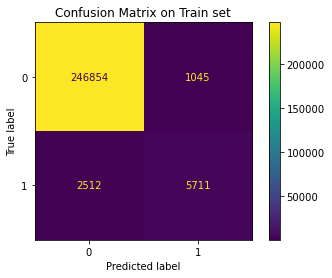

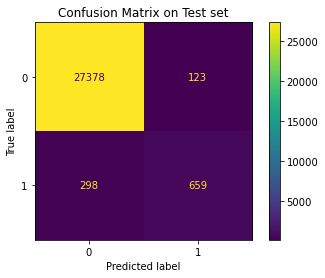

In [38]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_dt, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_dt, X_test, y_test, ax=ax) 
plt.show()

In [39]:
print(classification_report(y_train, y_train_pred_dt))
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.85      0.69      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.92      0.85      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.84      0.69      0.76       957

    accuracy                           0.99     28458
   macro avg       0.92      0.84      0.88     28458
weighted avg       0.98      0.99      0.98     28458



La recall sur le test est légérement supérieur pour `DecisionTree` par rapport à `LogisticRegression`

### RandomForest

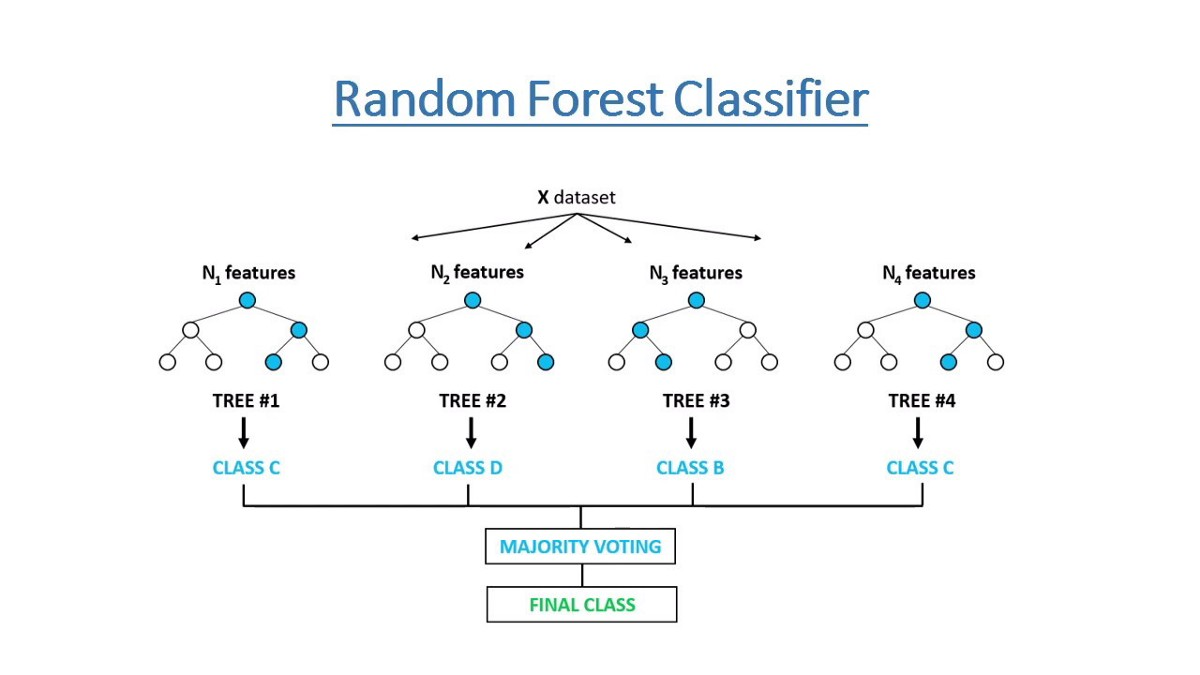

**Random Forest** fait partie des techniques d'apprentissage automatique. C'est tout simplement un regroupement de **Decision Trees**. Cet algorithme combine les concepts de sous-espaces aléatoires et de **bagging**. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

La proposition de **Breiman** vise à corriger plusieurs inconvénients connus de la méthode initiale, comme la sensibilité des arbres uniques à l'ordre des prédicteurs, en calculant un ensemble de $B$ arbres partiellement indépendants. Chaque arbre est entraîné sur un sous-ensemble du dataset et donne un résultat binaire. Les résultats de tous les arbres de décision sont alors combinés pour donner une réponse finale. Chaque arbre « vote » (oui ou non) et la réponse finale est celle qui a eu la majorité de vote.

Une brève description de la méthode(**bagging**) est:

1. On découpe notre dataset en plusieurs sous-ensembles aléatoirement $B$ constitués d’échantillons(d’où le `Random` dans **Random Forest**) par un double processus d'échantillonnage :
    * sur les observations, en utilisant un tirage avec remise d'un nombre $N$ d'observations identique à celui des données d'origine (technique connue sous le nom de **bootstraping**),
    * sur les $p$ prédicteurs, en n'en retenant qu'un échantillon de cardinal $m<\sqrt {p}$ (la limite n'est qu'indicative).
2. Sur chaque échantillon, on entraîne un arbre de décision selon une des techniques connues, en limitant sa croissance par validation croisée (il y a autant de modèles que de sous-ensembles)
3. On stocke les $B$ prédictions de la variable d'intérêt pour chaque observation d'origine, en combinant tous les résultats des modèles (avec un système de vote par exemple) ce qui nous donne un résultat final
4. La prédiction de la Random Forest est alors un simple vote majoritaire (Ensemble learning : bagging, boosting, stacking).

la **Random Forest** partagent les mêmes hyperparamètres que **Decision Tree** à l'exception d'un qui est 'n_estimators' : il permet de choisir le nombre d'arbres que va contenir le **Random Forest**. C'est le nombre d'arbres que l'on veut construire avant de prendre le **vote maximum** ou les **moyennes des prédictions**. Un nombre plus élevé d'arborescences nous donne de meilleures performances mais ralentit notre vitesse de calcul.

In [79]:
scores_rf = cross_val_score(pip1[1][2], X_train, y_train, cv=10)
print(scores_rf.mean())
print(scores_rf.std())

0.9845893762256972
0.00044033931879891504


In [89]:
params = {
    'max_depth': [7,8,9],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [3,4,5],
    'n_estimators': [55,60,65,70]
}

gridsearch = GridSearchCV(pip1[1][2], param_grid = params, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 8, 9], 'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [55, 60, 65, 70]})

In [166]:
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}

gridsearch = GridSearchCV(pip1[1][2], param_grid = params, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [90]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 55}
Best R2 score :  0.9860808507206732


In [140]:
with open('./model/random_forest_model', 'wb') as f:
    pickle.dump(gridsearch, f)

In [106]:
y_train_pred_rf = gridsearch.predict(X_train)
y_test_pred_rf = gridsearch.predict(X_test)

In [107]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_rf))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_rf))

f1-score sur le train set :  0.7683945920239147
f1-score sur le test set :  0.7591836734693876


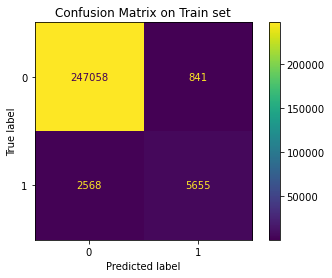

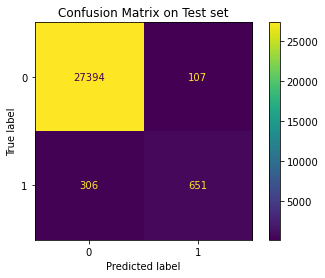

In [93]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) 
plt.show()

In [172]:
print(classification_report(y_train, y_train_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.87      0.68      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.86      0.67      0.75       957

    accuracy                           0.99     28458
   macro avg       0.92      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



### SVM

In [9]:
scores_svm = cross_val_score(pip1[1][3], X_train, y_train, cv=5)
print(scores_svm.mean())
print(scores_svm.std())

0.9859559086772023
0.00042343116297213426


In [11]:
param_grid={'C': [1, 5, 10, 50],
            'gamma': [0.0001, 0.0005, 0.001, 0.005]}

gridsearch_svm = GridSearchCV(pip1[1][3], param_grid = param_grid, cv=5)
gridsearch_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 5, 10, 50],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005]})

In [13]:
print("Best hyperparameters : ", gridsearch_svm.best_params_)
print("Best R2 score : ", gridsearch_svm.best_score_)

Best hyperparameters :  {'C': 50, 'gamma': 0.0005}
Best R2 score :  0.9861628418596793


In [12]:
y_train_pred_svm = gridsearch_svm.predict(X_train)
y_test_pred_svm = gridsearch_svm.predict(X_test)

In [14]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_svm))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_svm))

f1-score sur le train set :  0.7557546519641626
f1-score sur le test set :  0.7544483985765125


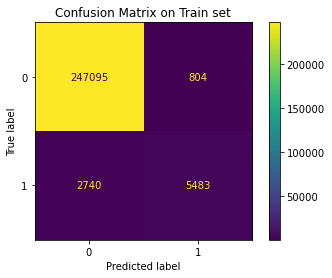

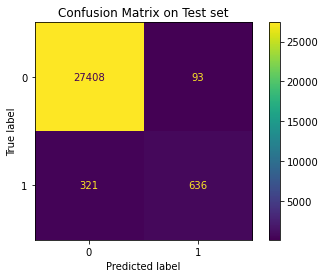

In [15]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_svm, X_train, y_train, ax=ax)
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_svm, X_test, y_test, ax=ax) 
plt.show()

In [16]:
print(classification_report(y_train, y_train_pred_svm))
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.87      0.67      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.83      0.87    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.87      0.66      0.75       957

    accuracy                           0.99     28458
   macro avg       0.93      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



In [17]:
import pickle

In [ ]:
with open('./model/random_forest_model', 'wb') as f:
    pickle.dump(gridsearch, f)

In [19]:
with open('./model/svc_model', 'rb') as f:
    mp = pickle.load(f)

In [20]:
mp.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
mp.score(X_test, y_test)

0.9854522454142948

In [24]:
data_without_labels = pd.read_csv('./src/conversion_data_test.csv')

In [25]:
data_without_labels.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [60]:
data_without_labels.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
dtype: int64

In [50]:
X = pip1[0].transform(data_without_labels)

In [51]:
data = {
    'converted': mp.predict(X)
}

In [54]:
y_predictions = pd.DataFrame(columns=['converted'],data=data)
y_predictions.to_csv('./src/conversion_data_test_predictions_test1_david_tg.csv', index=False)

In [53]:
y_predictions

,converted
0,1
1,0
2,0
3,0
4,0
...,...
31615,0
31616,0
31617,0
31618,1


### Test with Lasso and Ridge

### RidgeClassifier

In [58]:
from sklearn.linear_model import RidgeClassifier, Lasso

In [66]:
ridge1 = RidgeClassifier()
ridge1.fit(X_train, y_train)

print("R2 score sur le training set : ", ridge1.score(X_train, y_train))
print("R2 score sur le test set : ", ridge1.score(X_test, y_test))

R2 score sur le training set :  0.9696082335761863
R2 score sur le test set :  0.9682690280413241


In [67]:
param_grid={'alpha':  [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}

gridsearch_ridge = GridSearchCV(ridge1, param_grid=param_grid, cv=5)
gridsearch_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]})

In [68]:
print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R2 score : ", gridsearch_ridge.best_score_)

Best hyperparameters :  {'alpha': 0.01}
Best R2 score :  0.9696082345185468


In [69]:
print("R2 score sur le training set : ", gridsearch_ridge.score(X_train, y_train))
print("R2 score sur le test set : ", gridsearch_ridge.score(X_test, y_test))

R2 score sur le training set :  0.9696082335761863
R2 score sur le test set :  0.9682690280413241


In [70]:
y_train_pred_ridge = gridsearch_ridge.predict(X_train)
y_test_pred_ridge = gridsearch_ridge.predict(X_test)

In [71]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_ridge))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_ridge))

f1-score sur le train set :  0.1013622719926114
f1-score sur le test set :  0.10682492581602374


### Lasso

In [72]:
lasso = Lasso()

params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30]
}
best_lasso = GridSearchCV(lasso, param_grid = params, cv = 5)
best_lasso.fit(X_train, y_train)

print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Best hyperparameters :  {'alpha': 1}
Best R2 score :  -1.4837207351625636e-05


### RF

In [ ]:
rfc = RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=4, n_estimators=60)

In [83]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=60)

In [84]:
y_train_pred_randomf = rfc.predict(X_train)
y_test_pred_randomf = rfc.predict(X_test)

In [85]:
print("R2 score sur le training set : ", rfc.score(X_train, y_train))
print("R2 score sur le test set : ", rfc.score(X_test, y_test))

R2 score sur le training set :  0.9863892988497669
R2 score sur le test set :  0.9849954318645021


In [87]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_randomf))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_randomf))

f1-score sur le train set :  0.7609381429159238
f1-score sur le test set :  0.7468879668049793


In [94]:
param_grid={'C': [40,50,60],
            'gamma': [0.0005]}

gridsearch_svm = GridSearchCV(pip1[1][3], param_grid = param_grid, cv=5)
gridsearch_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [40, 50, 60], 'gamma': [0.0005]})

In [95]:
print("Best hyperparameters : ", gridsearch_svm.best_params_)
print("Best R2 score : ", gridsearch_svm.best_score_)

Best hyperparameters :  {'C': 50, 'gamma': 0.0005}
Best R2 score :  0.9861628418596793


### Optimize SVC

In [122]:
svc = SVC(C=48, gamma=0.0005, probability=True)

In [123]:
svc.fit(X_train,y_train)

SVC(C=48, gamma=0.0005, probability=True)

In [139]:
with open('./model/svc_proba_model', 'wb') as f:
    pickle.dump(svc, f)

In [100]:
y_train_pred_svc1 = svc.predict(X_train)
y_test_pred_svc1 = svc.predict(X_test)

In [102]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_randomf))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_randomf))

f1-score sur le train set :  0.7609381429159238
f1-score sur le test set :  0.7468879668049793


In [103]:
print(classification_report(y_train, y_train_pred_svc1))
print(classification_report(y_test, y_test_pred_svc1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.87      0.67      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.83      0.87    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.87      0.66      0.75       957

    accuracy                           0.99     28458
   macro avg       0.93      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



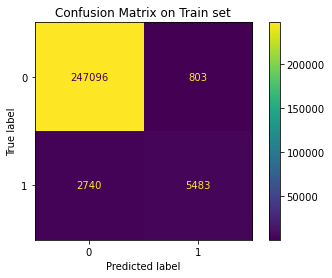

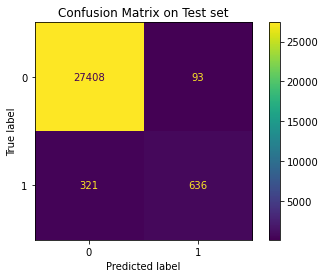

In [105]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(svc, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, ax=ax) 
plt.show()

### Voting

Il y a 3 techniques d'Ensemble Learning (cad qui utilise un regroupement de modèle de machine learning pour prendre une décision et faire un choix dans sa prédiciton):

* **Voting** :
* **Bagging** :
* **Boosting** :

#### Biais

Le **biais** fait référence à l'erreur qui est introduite en se rapprochant d'un problème réel, qui peut être extrêmement compliqué, par un modèle beaucoup plus simple. Donc, si la vraie relation est complexe et qu'on essaye d'utiliser la régression linéaire, cela entraînera sans aucun doute un biais dans l'estimation de f(X). Peu importe le nombre d'observations que l'on est, il est impossible de produire une prédiction précise si on utilise un algorithme restrictif/simple, alors que la vraie relation est très complexe.

#### Variance

La **variance** fait référence à la quantité dont notre estimation de f(X) changerait si nous l'estimions à l'aide d'un training set différent. Étant donné que les données du train sont utilisées pour ajuster la méthode d'apprentissage statistique, différents training sets se traduiront par une estimation différente. Mais idéalement, l'estimation de f(X) ne devrait pas trop varier entre les training set. Cependant, si une méthode a une variance élevée, de petits changements dans les données du train peuvent entraîner de grands changements dans f(X).

#### Regle générale

Tout changement dans le dataset fournira une estimation différente, qui est très précise, lors de l'utilisation d'une méthode statistique qui essaie de faire correspondre les points de données trop étroitement. Une règle générale est que, lorsqu'une méthode statistique essaie de faire correspondre plus étroitement les points de données ou lorsqu'une méthode plus flexible est utilisée, le **biais diminue**, mais la **variance augmente**.

Un **biais élevé (underfitting)** se produit lorsque le modèle se trompe avec une différence constante entre ses prédictions et les vrais valeurs mais est en underfitting car il n'est pas assez complexe pour prédire les bonnes données alors qu'une **variance élevée(overfitting)** se produit lorsque le modèle ne se trompe pas ou peu mais fait de l'overfitting à voiloir trouver toutes les données en devenant trop complexe (overfitting) il a dont du mal à généraliser.

Afin de minimiser l'erreur de test attendue, nous devons sélectionner une méthode d'apprentissage statistique qui atteint simultanément une faible variance et un faible biais. Il y a toujours un compromis entre ces valeurs car il est facile d'obtenir une méthode avec un **biais extrêmement faible** mais une **variance élevée** (par exemple, en traçant une courbe qui passe par chaque observation d'apprentissage) ou une méthode avec une **variance très faible** mais un **biais élevé** (en ajustant une ligne horizontale aux données).

In [124]:
voting = VotingClassifier(estimators=[("svc", svc), ("tree", gridsearch), ("svm", gridsearch_lr)], voting='soft') 
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(C=48, gamma=0.0005, probability=True)),
                             ('tree',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(),
                                           param_grid={'max_depth': [7, 8, 9],
                                                       'min_samples_leaf': [4,
                                                                            5,
                                                                            6],
                                                       'min_samples_split': [3,
                                                                             4,
                                                                             5],
                                                       'n_estimators': [55, 60,
                                                                        65,
                                                                        70]})),
                             ('svm',
                              GridSearchCV(cv=5, estimator=LogisticRegression(),
                                           param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                       'penalty': ['l1',
                                                                   'l2']}))],
                 voting='soft')

In [121]:
from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(svc)
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=48, gamma=0.0005))

In [127]:
voting_pred_train = voting.predict(X_train)
voting_pred_test = voting.predict(X_test)

In [126]:
print("Accuracy on training set : ", voting.score(X_train, y_train))
print("Accuracy on test set : ", voting.score(X_test, y_test))

Accuracy on training set :  0.9863932032390814
Accuracy on test set :  0.9852765478951437


In [128]:
print("f1-score sur le train set : ", f1_score(y_train, voting_pred_train))
print("f1-score sur le test set : ", f1_score(y_test, voting_pred_test))

f1-score sur le train set :  0.7637127940877348
f1-score sur le test set :  0.7545401288810779


In [129]:
print(classification_report(y_train, voting_pred_train))
print(classification_report(y_test, voting_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.86      0.68      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.86      0.67      0.75       957

    accuracy                           0.99     28458
   macro avg       0.92      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



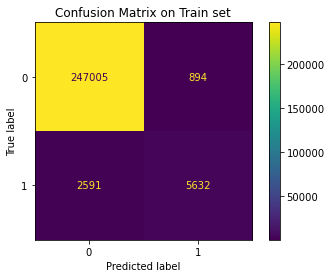

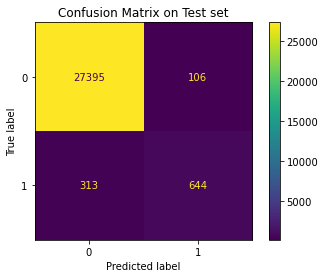

In [130]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(voting, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(voting, X_test, y_test, ax=ax) 
plt.show()

In [138]:
with open('./model/stacking_model', 'wb') as f:
    pickle.dump(stacking, f)

In [133]:
stacking = StackingClassifier(estimators = [("svc", svc), ("tree", gridsearch), ("svm", gridsearch_lr)], cv=3)

preds = stacking.fit_transform(X_train, y_train)

In [134]:
print("Accuracy on training set : ", stacking.score(X_train, y_train))
print("Accuracy on test set : ", stacking.score(X_test, y_test))

Accuracy on training set :  0.9858661106816283
Accuracy on test set :  0.9852765478951437


In [135]:
print("f1-score sur le train set : ", f1_score(y_train, voting_pred_train))
print("f1-score sur le test set : ", f1_score(y_test, voting_pred_test))

f1-score sur le train set :  0.7637127940877348
f1-score sur le test set :  0.7545401288810779


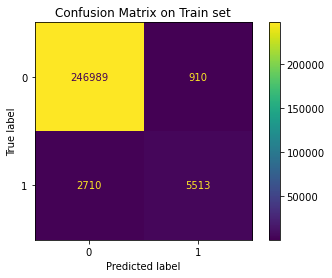

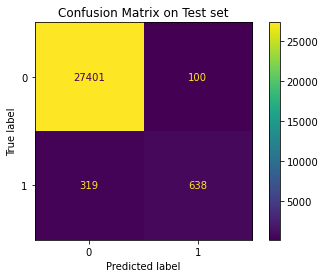

In [144]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(stacking, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(stacking, X_test, y_test, ax=ax) 
plt.show()

In [ ]:
xgboost = XGBClassifier()

params = {
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3], 
    'n_estimators': [2, 4, 6, 8,] 
}

gridsearch = GridSearchCV(xgboost, param_grid = params, cv=3) 
gridsearch.fit(X_train, Y_train)